In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


# Introduction

Now I need to think my pipeline again.

1. Split feature extractor (standard scaler, etc) and model (Pivot, NN, TangentProp, Siamnese, etc)
    - Issue What about augmenting the data ? This is crucial for every models...
    - TP needs : Skewing -> tangents, Scaler, NN + JNN
    - NN needs : Scaler, NN
    - PAN needs : Skewing -> augment and z, Scaler, NN + Adv
    - Sia needs : Skewing -> augment and z, Scaler, NN x2
2. Allow for cascade techniques
3. Easilly access training curves, etc.
    - Implement hooks for init, iteration, epoch
4. Get name of the complete model or ID + description of its hyper-params


#  Pizza Toy datasets

## Data

In [2]:
import datawarehouse as dw

In [3]:
X, y = dw.make_pizza_slice()

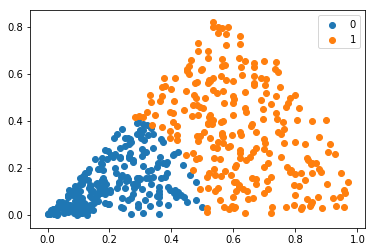

In [4]:

plt.scatter(X[y==0, 0], X[y==0, 1], label='0')
plt.scatter(X[y==1, 0], X[y==1, 1], label='1')
plt.legend()
plt.show()


## Skewing

In [5]:
def skew(X, z):
    x = X[:, 0]
    y = X[:, 1]
    theta = np.arctan2(y, x) + z
    r = np.sqrt(x*x + y*y)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    X_skew = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1)], axis=1)
    return X_skew

# def skew(X, z=0):
#     """
#     Skew the data.
    
#     Parameters
#     ----------
#         X : the given 2D data
#         z : the nuisance parameter
#     Return
#     ------
#         X_skewed :
#     """
#     X_2 = X*X
#     rho = np.sqrt(X_2[:,0]+X_2[:,1])
#     theta = np.arctan2(X[:, 1], X[:, 0]) # WTF ! arctan2(x*x / y*y) ???
#     theta = theta + z
#     X_2[:, 0] = rho*np.cos(theta)
#     X_2[:, 1] = rho*np.sin(theta)
#     return X_2

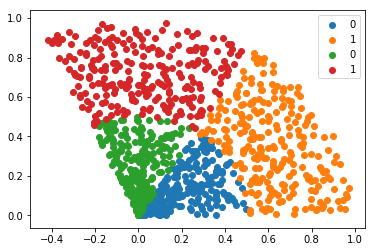

In [6]:
X_skew = skew(X, 45)
plt.scatter(X[y==0, 0], X[y==0, 1], label='0')
plt.scatter(X[y==1, 0], X[y==1, 1], label='1')
plt.scatter(X_skew[y==0, 0], X_skew[y==0, 1], label='0')
plt.scatter(X_skew[y==1, 0], X_skew[y==1, 1], label='1')
plt.legend()
plt.show()


# Base

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib


In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable


In [9]:
class WeightedCrossEntropyLoss(nn.Module):
    def forward(self, input, target, weight):
        element_loss = F.cross_entropy(input, target, reduce=False)
        loss = torch.mean(element_loss * weight)
        return loss


In [10]:
from models.net.weighted_criterion import WeightedMSELoss

# Neural net

## Networks

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 12)
        self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(12, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def reset_parameters(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()
        self.fc3.reset_parameters()


## Model

In [12]:
from models.net import NeuralNetClassifier
from models.net import NeuralNetRegressor

In [13]:
import os
from sklearn.externals import joblib

class NeuralNetModel(BaseEstimator, ClassifierMixin):
    def __init__(self, n_steps=5000, batch_size=20, learning_rate=1e-3, cuda=False, verbose=0):
        super().__init__()
        self.n_steps = n_steps
        self.batch_size = batch_size
        self.cuda = cuda
        self.verbose = verbose
        
        self.net = Net()
        
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(self.net.parameters(), lr=learning_rate)
        self.criterion = WeightedCrossEntropyLoss()
        
        self.scaler = StandardScaler()
        self.clf = NeuralNetClassifier(self.net, self.criterion, self.optimizer, 
                                       n_steps=self.n_steps, batch_size=self.batch_size)

    def fit(self, X, y, sample_weight=None):
        X = self.scaler.fit_transform(X)
        self.clf.fit(X, y)
        return self
    
    def predict(self, X):
        X = self.scaler.transform(X)
        y_pred = self.clf.predict(X)
        return y_pred
    
    def predict_proba(self, X):
        X = self.scaler.transform(X)
        proba = self.clf.predict_proba(X)
        return proba

    def save(self, dir_path):
        path = os.path.join(dir_path, 'weights.pth')
        torch.save(self.net.state_dict(), path)
        
        path = os.path.join(dir_path, 'Scaler.pkl')
        joblib.dump(self.scaler, path)
        return self
    
    def load(self, dir_path):
        path = os.path.join(dir_path, 'weights.pth')
        if self.cuda:
            self.net.load_state_dict(torch.load(path))
        else:
            self.net.load_state_dict(torch.load(path, map_location=lambda storage, loc: storage))

        path = os.path.join(dir_path, 'Scaler.pkl')
        self.scaler = joblib.load(path)
        return self
    
    def describe(self):
        return dict(name='neural_net', learning_rate=self.learning_rate)
    


## Training

In [14]:
model = NeuralNetModel(n_steps=1000)

In [15]:
#model.fit(X[:50], y[:50])
model.fit(X, y)


NeuralNetModel(batch_size=20, cuda=False, learning_rate=0.001, n_steps=1000,
        verbose=0)

In [16]:
model.score(X, y)

0.998

In [18]:
model.save('../savings')

NeuralNetModel(batch_size=20, cuda=False, learning_rate=0.001, n_steps=1000,
        verbose=0)

In [19]:
model.load("../savings")

NeuralNetModel(batch_size=20, cuda=False, learning_rate=0.001, n_steps=1000,
        verbose=0)

## Evaluation

In [20]:
def bound(X, y, predict_fn, ax=None, cmap='PuBuGn'):
    """
    Plot the bounds of a 2D dataset (X,y) given a probability prediction
    function.
    
    Params
    ------
        X: the data
        y: the true labels
        predict_fn: the probability prediction function
        ax: (default=None) the axes
    Return
    ------
        fig: the figure
        ax: the axes
    """
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                         np.arange(y_min, y_max, .02))
    Z = predict_fn( (np.c_[xx.ravel(), yy.ravel()]).astype(np.float32) )
    Z = np.array(Z)[:, 1]
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    m = ax.contourf(xx, yy, Z, cmap=cmap, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='b', cmap=m.cmap)
    cb = fig.colorbar(m)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return fig, ax

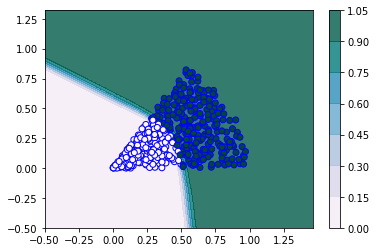

In [21]:
bound(X, y, model.predict_proba)
plt.show()

In [22]:
print(model.get_params())

{'batch_size': 20, 'cuda': False, 'learning_rate': 0.001, 'n_steps': 1000, 'verbose': 0}


# Data Augmentation

In [23]:
class DataAugmenter(object):
    def __init__(self):
        super().__init__()
    
    def augment(self, X, y, sample_weight=None):
        raise NotImplementedError
    
    def __call__(self, X, y, sample_weight=None):
        return self.augment(X, y, sample_weight=None)
    
    def sample_z(self, size):
        raise NotImplementedError


In [24]:
class NormalDataAugmenter(DataAugmenter):
    def __init__(self, skewing_function, width=1, center=0, n_augment=2):
        super().__init__()
        self.skewing_function = skewing_function
        self.width = width
        self.center = center
        self.n_augment = n_augment
    
    def augment(self, X, y, sample_weight=None):
        z_list = [self.sample_z( size=X.shape[0] ) for _ in range(self.n_augment)]
        X = np.concatenate( [X,] + [ self.skewing_function(X, z) for z in z_list ], axis=0)
        y = np.concatenate( [y,] + [y for _ in range(self.n_augment) ], axis=0)
        if sample_weight is not None:
            W = np.concatenate( [sample_weight,] + [sample_weight for _ in range(self.n_augment) ], axis=0)
            return X, y, W
        return X, y, sample_weight

    def sample_z(self, size):
        z = np.random.normal( loc=self.center, scale=self.width, size=size )
        return z

## Model

In [25]:
from models.net import NeuralNetClassifier

In [26]:
import os
from sklearn.externals import joblib

class AugmentedNeuralNetModel(BaseEstimator, ClassifierMixin):
    def __init__(self, n_steps=5000, batch_size=20, learning_rate=1e-3, width=1, n_augment=2,
                 cuda=False, verbose=0):
        super().__init__()
        self.n_steps = n_steps
        self.batch_size = batch_size
        self.cuda = cuda
        self.verbose = verbose
        
        self.net = Net()
        
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(self.net.parameters(), lr=learning_rate)
        self.criterion = WeightedCrossEntropyLoss()
        
        
        self.n_augment = n_augment
        self.width = width
        self.augmenter = NormalDataAugmenter(skew, width=width, n_augment=n_augment)

        self.scaler = StandardScaler()
        self.clf = NeuralNetClassifier(self.net, self.criterion, self.optimizer, 
                                       n_steps=self.n_steps, batch_size=self.batch_size)

    def fit(self, X, y, sample_weight=None):
        X, y, sample_weight = self.augmenter(X, y, sample_weight)
        X = self.scaler.fit_transform(X)
        self.clf.fit(X, y)
        return self
    
    def predict(self, X):
        X = self.scaler.transform(X)
        y_pred = self.clf.predict(X)
        return y_pred
    
    def predict_proba(self, X):
        X = self.scaler.transform(X)
        proba = self.clf.predict_proba(X)
        return proba

    def save(self, dir_path):
        path = os.path.join(dir_path, 'weights.pth')
        torch.save(self.net.state_dict(), path)
        
        path = os.path.join(dir_path, 'Scaler.pkl')
        joblib.dump(self.scaler, path)
        return self
    
    def load(self, dir_path):
        path = os.path.join(dir_path, 'weights.pth')
        if self.cuda:
            self.net.load_state_dict(torch.load(path))
        else:
            self.net.load_state_dict(torch.load(path, map_location=lambda storage, loc: storage))

        path = os.path.join(dir_path, 'Scaler.pkl')
        self.scaler = joblib.load(path)
        return self
    
    def describe(self):
        return dict(name='neural_net', learning_rate=self.learning_rate)
    


## Training

In [27]:
model = AugmentedNeuralNetModel(n_steps=1000, width=1)

In [28]:
model.fit(X, y)

AugmentedNeuralNetModel(batch_size=20, cuda=False, learning_rate=0.001,
            n_augment=2, n_steps=1000, verbose=0, width=1)

In [29]:
model.score(X, y)

0.98999999999999999

In [30]:
model.augmenter.sample_z(35)

array([-0.31050093, -0.27058206, -0.37301969,  0.74761979,  0.11230471,
       -1.01010932, -0.48618876, -1.2658278 , -0.69713872, -1.31942161,
        0.77078769,  0.21257714, -1.00796685, -3.02518497,  0.73816426,
       -0.65771813, -0.22781717,  1.23337493,  0.54886188, -0.47171268,
       -0.4219034 , -0.75319133,  0.5471248 ,  1.52309649,  1.17556412,
       -1.35081376, -1.20751075, -1.01536891, -0.65158399,  0.37362232,
       -0.11290571,  0.84686539,  0.83335741,  0.02661428, -0.54642993])

##  Evaluation


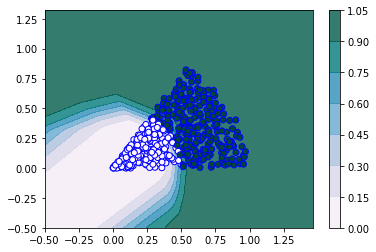

In [31]:
bound(X, y, model.predict_proba)
plt.show()

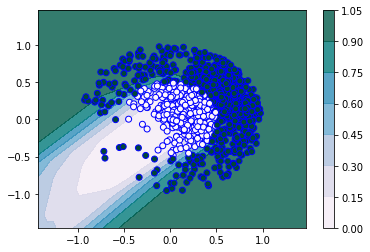

In [32]:
X_aug, y_aug, _ = model.augmenter(X, y)
bound(X_aug, y_aug, model.predict_proba)
plt.show()

# Tangent Prop

## Tangent computer

In [33]:
class TangentExtractor(object):
    def __init__(self, skewing_function, alpha=1e-2):
        super().__init__()
        self.skewing_function = skewing_function
        self.alpha = alpha

    def compute_tangent(self, X):
        """ The approximate formula to get the tangent. """
        X_plus = self.skewing_function(X, z=self.alpha)
        X_minus = self.skewing_function(X, z=-self.alpha)
        return ( X_plus - X_minus ) / ( 2 * self.alpha )

class TangentComputer(object):
    def __init__(self):
        super().__init__()

    def compute_tangent(self, X):
        """ The real formula to get the tangent. """
        X_2 = X*X
        rho = np.sqrt(X_2[:,0]+X_2[:,1])
        theta = np.arctan2(X[:, 1], X[:, 0])
        theta = theta
        X_2[:, 0] = -rho*np.sin(theta)
        X_2[:, 1] = rho*np.cos(theta)
        return X_2

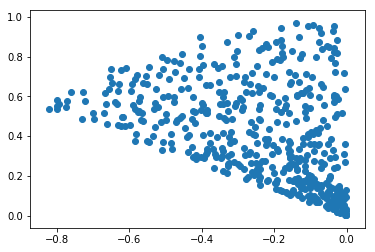

In [34]:
te = TangentExtractor(skew, alpha=1e-6)

T_approx = te.compute_tangent(X)

plt.scatter(T_approx[:, 0], T_approx[:, 1])
plt.show()

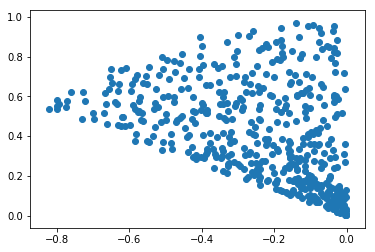

In [35]:
te = TangentComputer()

T = te.compute_tangent(X)

plt.scatter(T[:, 0], T[:, 1])
plt.show()

## Network structure

In [36]:
from models.net.tangent_prop import DSoftPlus
from models.net.tangent_prop import Bias

class JNet(nn.Module):
    def __init__(self):
        super(JNet, self).__init__()
        self.fc1 = nn.Linear(2, 5, bias=False)
        self.bias1 = Bias(2, 5)
        self.fc2 = nn.Linear(5, 5, bias=False)
        self.bias2 = Bias(5, 5)
        self.fc3 = nn.Linear(5, 5, bias=False)
        self.bias3 = Bias(5, 5)
        self.fc4 = nn.Linear(5, 2, bias=False)
        self.bias4 = Bias(5, 2)

    def forward(self, x, jx):
        x = self.bias1(self.fc1(x))
        jx = self.fc1(jx) * DSoftPlus()(x)
        x = F.softplus(x)

        x = self.bias2(self.fc2(x))
        jx = self.fc2(jx) * DSoftPlus()(x)
        x = F.softplus(x)

        x = self.bias3(self.fc3(x))
        jx = self.fc3(jx) * DSoftPlus()(x)
        x = F.softplus(x)

        x = self.bias4(self.fc4(x))
        jx = self.fc4(jx)
        return x, jx

    def reset_parameters(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()
        self.fc3.reset_parameters()
        self.fc4.reset_parameters()
        self.bias1.reset_parameters()
        self.bias2.reset_parameters()
        self.bias3.reset_parameters()
        self.bias4.reset_parameters()



## Model

In [37]:
from models.net import TangentPropClassifier

In [38]:
import os
from sklearn.externals import joblib

class TangentPropModel(BaseEstimator, ClassifierMixin):
    def __init__(self, skewing_function, n_steps=5000, batch_size=20, learning_rate=1e-3, trade_off=1, alpha=1e-2, cuda=False, verbose=0):
        super().__init__()
        self.skewing_function = skewing_function
        self.n_steps = n_steps
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.trade_off = trade_off
        self.alpha = alpha
        self.cuda = cuda
        self.verbose = verbose
        
        self.jnet = JNet()
        
        self.optimizer = optim.Adam(self.jnet.parameters(), lr=learning_rate)
        self.criterion = WeightedCrossEntropyLoss()
        
        self.tangent_extractor = TangentExtractor(skewing_function, alpha=alpha)
#         self.tangent_extractor = TangentComputer()

        self.scaler = StandardScaler()
        self.clf = TangentPropClassifier(self.jnet, self.criterion, self.optimizer, 
                                         n_steps=self.n_steps, batch_size=self.batch_size,
                                         trade_off=trade_off)

    def fit(self, X, y, sample_weight=None):
        T = self.tangent_extractor.compute_tangent(X)
        X = self.scaler.fit_transform(X)
        self.clf.fit(X, y, T)
        return self
    
    def predict(self, X):
        X = self.scaler.transform(X)
        y_pred = self.clf.predict(X)
        return y_pred
    
    def predict_proba(self, X):
        X = self.scaler.transform(X)
        proba = self.clf.predict_proba(X)
        return proba

    def save(self, dir_path):
        path = os.path.join(dir_path, 'weights.pth')
        torch.save(self.jnet.state_dict(), path)
        
        path = os.path.join(dir_path, 'Scaler.pkl')
        joblib.dump(self.scaler, path)
        return self
    
    def load(self, dir_path):
        path = os.path.join(dir_path, 'weights.pth')
        if self.cuda:
            self.jnet.load_state_dict(torch.load(path))
        else:
            self.jnet.load_state_dict(torch.load(path, map_location=lambda storage, loc: storage))

        path = os.path.join(dir_path, 'Scaler.pkl')
        self.scaler = joblib.load(path)
        return self
    
    def describe(self):
        return dict(name='neural_net', learning_rate=self.learning_rate)
    


## Training

In [39]:
model = TangentPropModel(skew, n_steps=5000, learning_rate=0.05, trade_off=1)

In [40]:
model.fit(X, y)

AttributeError: module 'torch' has no attribute 'square'

In [ ]:
model.score(X, y)

## Evaluation

In [ ]:
bound(X, y, model.predict_proba)
plt.show()

# Pivot adversarial

In [ ]:
class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 12)
        self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(12, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def reset_parameters(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()
        self.fc3.reset_parameters()

class RNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 12)
        self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(12, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def reset_parameters(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()
        self.fc3.reset_parameters()

### Get z

In [ ]:
class ZComputer(object):
    def __init__(self):
        super().__init__()

    def compute_z(self, X):
        x = X[:, 0]
        y = X[:, 1]
        z = np.arctan2(y, x)
        return z
    

In [ ]:
z = ZComputer().compute_z(X)

In [ ]:
threshold = 0.5  # rad
plt.scatter(X[z<threshold, 0], X[z<threshold, 1], label='0')
plt.scatter(X[z>threshold, 0], X[z>threshold, 1], label='1')
plt.legend()
plt.show()


## Model


Non ! Ça va pas du tout !

Pivot Classifier a trop d'élément. C'est la preuve qu'il pourrait être découper en morceau.
Pk pas 1 classifieur + 1 regresseur en entrée ? 
Ils ont déjà :
- leur network
- leur criterion
- leur otpimiseur


In [ ]:
from models.net.minibatch import EpochShuffle, OneEpoch
from models.net.utils import make_variable
from itertools import islice

class PivotTrainer(BaseEstimator, ClassifierMixin):
    def __init__(self, classifier, adversarial, droptimizer, n_steps, batch_size, n_recovery_steps=20,
                 trade_off=1, cuda=False, verbose=0):
        super().__init__()
        self.classifier = classifier
        self.adversarial = adversarial
        self.droptimizer = droptimizer
        self.n_steps = n_steps
        self.n_recovery_steps = n_recovery_steps
        self.batch_size = batch_size
        self.trade_off = trade_off
        self.cuda = cuda

    def fit(self, X, y, z, sample_weight=None):
        if sample_weight is None:
            sample_weight = np.ones_like(y)        
        
        X = X.astype(np.float32)
        z = z.astype(np.float32)
        sample_weight = sample_weight.astype(np.float32)
        y = y.astype(np.int64)

        batch_size = self.batch_size
        n_steps = self.n_steps

#         self.classifier.n_steps = 1
#         self.regressor.n_steps = self.n_recovery_steps
#         self.classifier.net.reset_parameters()
#         self.adversarial.net.reset_parameters()
        batch_gen_DR = EpochShuffle(X, y, z, sample_weight, batch_size=batch_size)
        batch_gen_R = EpochShuffle(X, z, sample_weight, batch_size=batch_size)
        self.classifier.net.train() # train mode
        self.adversarial.net.train() # train mode
        for i, (X_batch, y_batch, z_batch, w_batch) in enumerate(islice(batch_gen_DR, self.n_steps)):
            X_batch = make_variable(X_batch, cuda=self.cuda)
            z_batch = make_variable(z_batch, cuda=self.cuda)
            w_batch = make_variable(w_batch, cuda=self.cuda)
            y_batch = make_variable(y_batch, cuda=self.cuda)
            self.droptimizer.zero_grad() # zero-out the gradients because they accumulate by default
            y_pred = self.classifier.net(X_batch)
            z_pred = self.adversarial.net(y_pred)
            loss_clf = self.classifier.criterion(y_pred, y_batch, w_batch) 
            loss_adv = self.adversarial.criterion(z_pred, z_batch, w_batch)
            loss = loss_clf - ( self.trade_off * loss_adv )
            loss.backward() # compute gradients
            self.droptimizer.step() # update params
#             if i % 30 == 0:
#                 print('clf loss :', loss_clf.data[0])
#                 print('adv loss :', loss_adv.data[0])

            for j, (X_batch, z_batch, w_batch) in enumerate(islice(batch_gen_R, self.n_recovery_steps)):
                X_batch = make_variable(X_batch, cuda=self.cuda)
                z_batch = make_variable(z_batch, cuda=self.cuda)
                w_batch = make_variable(w_batch, cuda=self.cuda)
                self.adversarial.optimizer.zero_grad() # zero-out the gradients because they accumulate by default
                y_pred = self.classifier.net(X_batch)
                z_pred = self.adversarial.net(y_pred)
                loss = self.adversarial.criterion(z_pred, z_batch, w_batch)
                loss.backward() # compute gradients
                self.adversarial.optimizer.step() # update params
#                 if i % 30 == 0:
#                     print('adv loss :', loss_adv.data[0])
        return self
    
    def predict(self, X):
        return None
    
    def predict_proba(self, X):
        return None


In [ ]:
import os
from collections import OrderedDict
from sklearn.externals import joblib

class PivotModel(BaseEstimator, ClassifierMixin):
    def __init__(self, n_clf_pre_training_steps=10, n_adv_pre_training_steps=10, n_steps=1000, n_recovery_steps=10,
                 batch_size=20, classifier_learning_rate=1e-3, adversarial_learning_rate=1e-3, trade_off=1,
                 cuda=False, verbose=0):
        super().__init__()
        self.n_clf_pre_training_steps = n_clf_pre_training_steps
        self.n_adv_pre_training_steps = n_adv_pre_training_steps
        self.n_steps = n_steps
        self.n_recovery_steps = n_recovery_steps
        self.batch_size = batch_size
        self.classifier_learning_rate = classifier_learning_rate
        self.adversarial_learning_rate = adversarial_learning_rate
        self.cuda = cuda
        self.verbose = verbose
        
        self.dnet = DNet()
        self.rnet = RNet()
        
        self.doptimizer = optim.Adam(self.dnet.parameters(), lr=classifier_learning_rate)
        self.dcriterion = WeightedCrossEntropyLoss()
        self.classifier = NeuralNetClassifier(self.dnet, self.dcriterion, self.doptimizer, 
                                              n_steps=n_clf_pre_training_steps, batch_size=batch_size, cuda=self.cuda)

        self.roptimizer = optim.Adam(self.rnet.parameters(), lr=adversarial_learning_rate)
        self.rcriterion = WeightedMSELoss()
#         self.regressor = NeuralNetRegressor(nn.Sequential(self.dnet, self.rnet), self.dcriterion, self.doptimizer, 
#                                               n_steps=n_adv_pre_training_steps, batch_size=batch_size, cuda=self.cuda)

        self.adversarial = NeuralNetRegressor(self.rnet, self.rcriterion, self.roptimizer, 
                                              n_steps=n_adv_pre_training_steps, batch_size=batch_size, cuda=self.cuda)
        
        self.droptimizer = optim.Adam(list(self.dnet.parameters()) + list(self.rnet.parameters()), lr=adversarial_learning_rate)
        self.pivot = PivotTrainer(self.classifier, self.adversarial, self.droptimizer,
                                 n_steps=self.n_steps, n_recovery_steps=n_recovery_steps, batch_size=batch_size,
                                 trade_off=trade_off)
        
        self.zcomputer = ZComputer()
        self.scaler = StandardScaler()
        
    def fit(self, X, y, sample_weight=None):
        z = self.zcomputer.compute_z(X)
        X = self.scaler.fit_transform(X)
#         self.classifier.fit(X, y, sample_weight=sample_weight)  # pre-training
#         y_pred = self.classifier.predict_proba(X)
#         self.adversarial.fit(y_pred, z, sample_weight=sample_weight)  # pre-training
        self.pivot.fit(X, y, z, sample_weight=sample_weight)
        return self
    
    def predict(self, X):
        X = self.scaler.transform(X)
        y_pred = self.classifier.predict(X)
        return y_pred
    
    def predict_proba(self, X):
        X = self.scaler.transform(X)
        proba = self.classifier.predict_proba(X)
        return proba

    def save(self, dir_path):
        # TODO
        return self
    
    def load(self, dir_path):
        # TODO
        return self
    
    def describe(self):
        # TODO
        return dict(name='pivot_model', learning_rate=self.learning_rate)
    


## Training

In [ ]:
model = PivotModel(n_steps=1000, n_recovery_steps=5, trade_off=0)

In [ ]:
model.fit(X, y)


In [ ]:
model.score(X, y)

## Evaluation

In [ ]:
bound(X, y , model.predict_proba)
plt.show()